<a href="https://colab.research.google.com/github/andreivasilescu24/MyCity-MyPlaces/blob/master/IBD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import multiprocessing
from collections import defaultdict

class GeospatialMRFramework:
    def __init__(self, num_workers=None):
        self.num_workers = num_workers or multiprocessing.cpu_count()

    def run_job(self, data, mapper_func, reducer_func):
        # 1. Partitioning (Split data for workers)
        chunk_size = len(data) // self.num_workers
        chunks = [data[i:i + chunk_size] for i in range(0, len(data), chunk_size)]

        # 2. Parallel MAP Phase
        with multiprocessing.Pool(self.num_workers) as pool:
            map_outputs = pool.map(mapper_func, chunks)

        # 3. SHUFFLE & SORT (Grouping by Key)
        shuffled_data = defaultdict(list)
        for worker_output in map_outputs:
            for key, value in worker_output:
                shuffled_data[key].append(value)

        # 4. REDUCE Phase
        final_results = {}
        for key, values in shuffled_data.items():
            final_results[key] = reducer_func(key, values)

        return final_results

In [ ]:
# Exemplu Mapper generic pentru București
def generic_urban_mapper(data_chunk):
    results = []
    for item in data_chunk:
        # Filtru de Veracity (ex: încredere > 0.9 conform Overture Maps)
        if item.get('confidence', 0) > 0.9:
            # Emitem (Cheia: Cartier, Valoarea: Tot obiectul pentru analize multiple)
            results.append((item['neighborhood'], item))
    return results

In [ ]:
import duckdb

# 1. Configurare conexiune Cloud
con = duckdb.connect()
con.execute("INSTALL spatial; LOAD spatial;")
con.execute("INSTALL httpfs; LOAD httpfs;")
con.execute("SET s3_region='us-west-2';")

# 2. Bounding Box pentru București
bbox_coords = {'xmin': 25.90, 'ymin': 44.28, 'xmax': 26.29, 'ymax': 44.60}

# 3. Interogare (Faza de Data Ingestion)
# Nota: Folosește cel mai recent release Overture (ex: 2024-12-18.0)
query = f"""
    SELECT
        names.primary AS name,
        categories.primary AS category,
        confidence,
        addresses[1].freeform AS address,
        ST_X(geometry) AS lon,
        ST_Y(geometry) AS lat
    FROM read_parquet('s3://overturemaps-us-west-2/release/2025-12-17.0/theme=places/*/*')
    WHERE bbox.xmin > {bbox_coords['xmin']} AND bbox.xmax < {bbox_coords['xmax']}
      AND bbox.ymin > {bbox_coords['ymin']} AND bbox.ymax < {bbox_coords['ymax']}
"""

# 4. Transformarea în lista de dicționare pentru framework-ul generic
# Aceasta devine variabila ta "raw_pois"
raw_pois = con.execute(query).df().to_dict('records')

print(f"Am obținut {len(raw_pois)} locații brute.")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Am obținut 64784 locații brute.


In [ ]:
import geopandas as gpd
from shapely import from_wkb

def get_divisions(subtypes):
    # 3. Interogare pentru division_area (Poligoanele cartierelor)
    # Subtipurile 'neighborhood' și 'macrohood' reprezintă diviziunile locale căutate
    query_divisions = f"""
    SELECT
        id,
        subtype,
        names.primary AS neighborhood_name,
        ST_AsText(geometry) AS wkt_geometry
    FROM read_parquet('s3://overturemaps-us-west-2/release/2025-12-17.0/theme=divisions/type=division_area/*')
    WHERE
        bbox.xmin > {bbox_coords['xmin']} AND bbox.xmax < {bbox_coords['xmax']}
        AND bbox.ymin > {bbox_coords['ymin']} AND bbox.ymax < {bbox_coords['ymax']}
        AND subtype IN ({subtypes})
    """

    df_div = con.execute(query_divisions).df()

    # 4. Crearea GeoDataFrame-ului folosind from_wkt
    # Această metodă este extrem de robustă pentru procesări de tip batch
    gdf_neighborhoods = gpd.GeoDataFrame(
        df_div,
        geometry=gpd.GeoSeries.from_wkt(df_div['wkt_geometry']),
        crs="EPSG:4326"
    )

    # 5. Crearea GeoDataFrame-ului
    gdf_neighborhoods = gdf_neighborhoods.drop(columns=['wkt_geometry'])

    return gdf_neighborhoods

localities = get_divisions("'locality'")
counties = get_divisions("'county'")
nhood = get_divisions("'neighborhood'")
macrohood = get_divisions("'macrohood'")
microhood = get_divisions("'microhood'")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
print(f"{len(localities)}")
print(f"{len(counties)}")
print(f"{len(nhood)}")
print(f"{len(macrohood)}")
print(f"{len(microhood)}")

23
12
59
79
8


In [ ]:
def subtype_mapper(data_chunk):
    results = []
    for item in data_chunk:
        # Extragem subtipul ca cheie și emitem valoarea 1
        subtype = item.get('subtype', 'unknown')
        results.append((subtype, 1))
    return results

def count_reducer(subtype, counts):
    return sum(counts)

In [ ]:
# Inițializăm framework-ul creat anterior
framework = GeospatialMRFramework(num_workers=4)
gdf_neighborhoods = get_divisions("'locality', 'neighborhood', 'macrohood', 'microhood','county'")
# 1. Convertim GeoDataFrame-ul în listă de dicționare (records)
# Aceasta este variabila ta "raw_data" pentru modelul Map-Reduce
raw_divisions = gdf_neighborhoods.to_dict('records')

# 2. Rulăm job-ul batch folosind lista de dicționare
subtype_distribution = framework.run_job(
    data=raw_divisions,
    mapper_func=subtype_mapper,
    reducer_func=count_reducer
)

# Afișăm rezultatele sintetizate
print("Distribuția tipurilor de diviziuni în București:")
for subtype, count in subtype_distribution.items():
    print(f" - {subtype}: {count} entități")

Distribuția tipurilor de diviziuni în București:
 - locality: 23 entități
 - microhood: 8 entități
 - county: 12 entități
 - macrohood: 79 entități
 - neighborhood: 59 entități


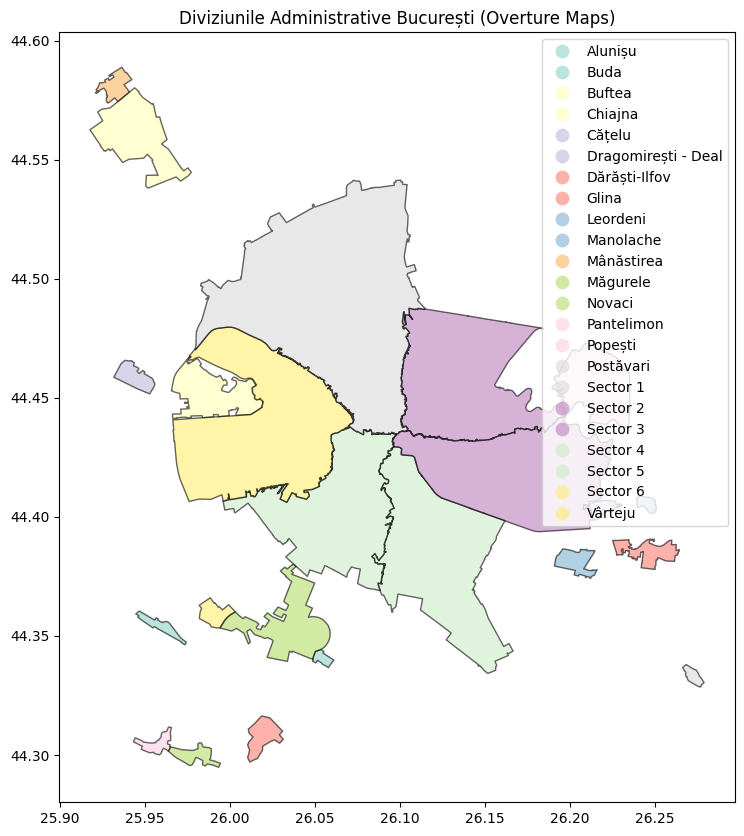

In [ ]:
import matplotlib.pyplot as plt

# Presupunem că ai deja gdf_neighborhoods din pașii anteriori
# Colorăm zonele în funcție de subtip (neighborhood, locality, etc.)
localities.plot(
    column='neighborhood_name',
    legend=True,
    figsize=(12, 10),
    edgecolor='black',
    alpha=0.6,
    cmap='Set3'
)

plt.title("Diviziunile Administrative București (Overture Maps)")
plt.show()

In [ ]:
!pip install leafmap

In [ ]:
import leafmap

def plot_divisions(divisions, name):
    m = leafmap.Map(center=[44.43, 26.10], zoom=12)

    m.add_gdf(
        divisions,
        layer_name=name,
        style={'color': 'blue', 'weight': 2, 'fillOpacity': 0.3}
    )

    return m

In [ ]:
plot_divisions(localities, 'Localitati')

Map(center=[44.43, 26.1], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [ ]:
plot_divisions(nhood, 'Cartiere')

Map(center=[44.43, 26.1], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [ ]:
plot_divisions(macrohood, 'Macrocartiere')

Map(center=[44.43, 26.1], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [ ]:
plot_divisions(microhood, 'Microcartiere')

Map(center=[44.43, 26.1], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [ ]:
counties = get_divisions("'county'")
plot_divisions(counties, 'Localitati')

Map(center=[44.43, 26.1], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [ ]:
urb = get_divisions("'locality','county'")
plot_divisions(urb, 'Localitati')

Map(center=[44.43, 26.1], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [ ]:
hood = get_divisions("'neighborhood','macrohood','microhood'")
plot_divisions(hood, 'Cartiere')

Map(center=[44.43, 26.1], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [ ]:
from shapely.strtree import STRtree # Index spațial ultra-rapid

# 1. Pregătim indexul pentru localități (urb) și cartiere (hood)
# Presupunem că urb și hood sunt GeoDataFrames
urb_tree = STRtree(urb.geometry.values)
hood_tree = STRtree(hood.geometry.values)

# Mapăm indexul înapoi la date pentru acces rapid
urb_map = {id(geom): row for geom, row in zip(urb.geometry, urb.to_dict('records'))}
hood_map = {id(geom): row for geom, row in zip(hood.geometry, hood.to_dict('records'))}

In [ ]:
def collection_reducer(key, pois):
    return pois

In [ ]:
from shapely.geometry import Point

def advanced_enrichment_mapper(poi_chunk):
    results = []
    for poi in poi_chunk:
        point = Point(poi['lon'], poi['lat'])

        # Locality
        loc_hits = urb_tree.query(point, predicate="intersects")
        if len(loc_hits) > 0:
            loc_pos = int(loc_hits[0])
            locality_name = urb.iloc[loc_pos]["neighborhood_name"]
            is_fallback = False
        else:
            loc_pos = int(urb_tree.nearest(point))
            locality_name = urb.iloc[loc_pos]["neighborhood_name"]
            is_fallback = True

        # Neighborhood (hood)
        hood_hits = hood_tree.query(point, predicate="intersects")
        if len(hood_hits) > 0:
            hood_pos = int(hood_hits[0])
            neighborhood_name = hood.iloc[hood_pos]["neighborhood_name"]
            is_fallback = False
        else:
            hood_pos = int(hood_tree.nearest(point))
            neighborhood_name = hood.iloc[hood_pos]["neighborhood_name"]
            is_fallback = True

        poi.update({
            "locality": str(locality_name),
            "neighborhood": str(neighborhood_name),
            "is_fallback": is_fallback
        })

        key = f"{locality_name}_{neighborhood_name}"
        results.append((key, poi))

    return results


In [ ]:
enriched_data = framework.run_job(
    data=raw_pois,
    mapper_func=advanced_enrichment_mapper,
    reducer_func=collection_reducer
)

In [ ]:
print(f"Procesare finalizată. Avem {len(enriched_data)} grupări unice.")

Procesare finalizată. Avem 212 grupări unice.


In [ ]:
for key, pois_list in enriched_data.items():
    print(f"Group Key: {key} No. POIs: {len(pois_list)}")

Group Key: Popești-Leordeni_Cartierul Danubiana No. POIs: 387
Group Key: Jilava_Apărătorii Patriei No. POIs: 17
Group Key: Jilava_Rahova No. POIs: 150
Group Key: Jilava_Family Residence No. POIs: 58
Group Key: Dărăști-Ilfov_Rahova No. POIs: 24
Group Key: Novaci_Rahova No. POIs: 1
Group Key: Popești_Cartierul Latin No. POIs: 54
Group Key: Buftea_Piaţa Mihai Eminescu No. POIs: 412
Group Key: Mânăstirea_Piaţa Mihai Eminescu No. POIs: 91
Group Key: Mogoșoaia_Băneasa No. POIs: 111
Group Key: Mogoșoaia_Piaţa Mihai Eminescu No. POIs: 33
Group Key: Mogoșoaia_Străulești Nord No. POIs: 228
Group Key: Mogoșoaia_Chitila - Triaj No. POIs: 14
Group Key: Chitila_Chitila - Triaj No. POIs: 206
Group Key: Chitila_Piaţa Mihai Eminescu No. POIs: 6
Group Key: Chitila_Giulești Sârbi No. POIs: 66
Group Key: Dragomirești - Deal_Giulești Sârbi No. POIs: 28
Group Key: Dragomirești - Deal_Militari No. POIs: 62
Group Key: Sector 1_Chitila - Triaj No. POIs: 32
Group Key: Sector 1_Străulești Nord No. POIs: 147
Grou

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import leafmap
import leafmap.colormaps as cm

# 1. Aplatizăm dicționarul enriched_data într-o listă de rânduri
all_rows = []
for key, poi_list in enriched_data.items():
    all_rows.extend(poi_list)

# 2. Creăm GeoDataFrame-ul final cu punctele procesate
# Acesta conține coloanele: name, category, lon, lat, locality, neighborhood, is_fallback
gdf_results = gpd.GeoDataFrame(all_rows)
gdf_results['geometry'] = [Point(x, y) for x, y in zip(gdf_results.lon, gdf_results.lat)]
gdf_results.set_crs("EPSG:4326", inplace=True)

# Ne asigurăm că atributele sunt String pentru a evita eroarea de hashing la groupby
gdf_results['neighborhood'] = gdf_results['neighborhood'].astype(str)

In [ ]:
# 3. Calculăm densitatea (numărul de restaurante/POI pe cartier)
# Aceasta este esența fazei de sinteză din procesarea batch
neighborhood_counts = gdf_results.groupby('neighborhood').size().reset_index(name='poi_count')

# 4. Îmbinăm cu poligoanele originale (variabila 'hood')
# Folosim 'left' join pentru a nu pierde poligoanele care nu au restaurante
gdf_final_map = hood.merge(
    neighborhood_counts,
    left_on='neighborhood_name',
    right_on='neighborhood',
    how='left'
).fillna(0)

In [ ]:
# 5. Pregătirea subseturilor pentru o vizualizare curată
validated_points = gdf_results[gdf_results['is_fallback'] == False].reset_index(drop=True)
fallback_points = gdf_results[gdf_results['is_fallback'] == True].reset_index(drop=True)

# 6. Generarea paletei dinamice pentru categorii (ex: restaurante, hoteluri)
unique_cats = validated_points['category'].unique().tolist()
custom_palette = cm.get_palette('tab20', n_class=len(unique_cats), hashtag=True)

# 7. Crearea Hărții
m = leafmap.Map(center=[44.43, 26.10], zoom=12)

# Adăugăm densitatea celor 212 grupări (Choropleth)
m.add_data(
    gdf_final_map,
    column='poi_count',
    scheme='FisherJenks',
    cmap='Blues',
    layer_name="Densitate pe Cartiere"
)

m

Map(center=[44.43, 26.1], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [ ]:
# 1. Calculăm centrul de greutate pentru fiecare din cele 212 grupări
summary_data = []
for key, pois in enriched_data.items():
    if not pois: continue

    # Cream un GeoSeries din punctele grupului pentru a calcula centrul
    temp_gdf = gpd.GeoDataFrame(pois)
    temp_gdf.set_geometry(gpd.points_from_xy(temp_gdf.lon, temp_gdf.lat), crs="EPSG:4326", inplace=True)

    # Calculăm centroidul geometric al grupului de puncte
    centroid = temp_gdf.geometry.unary_union.centroid

    summary_data.append({
        'key': key,
        'neighborhood': pois[0]['neighborhood'],
        'poi_count': len(pois),
        'lon': centroid.x,
        'lat': centroid.y
    })

gdf_centroids = gpd.GeoDataFrame(summary_data)

# 2. Vizualizare: Un singur cerc per cartier, mărimea depinde de numărul de locații
m = leafmap.Map(center=[44.43, 26.10], zoom=12)
m.add_circle_markers_from_xy(
    gdf_centroids, x="lon", y="lat",
    radius_column='poi_count', # Cercuri mai mari pentru zone mai dense
    color_column='neighborhood',
    layer_name="Centre de Greutate Cartiere"
)
m

Map(center=[44.43, 26.1], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [ ]:
# 1. Generăm poligoane de tip Convex Hull pentru fiecare grup
hulls_list = []
for key, pois in enriched_data.items():
    if len(pois) < 3: continue # Avem nevoie de min 3 puncte pentru un poligon

    temp_gdf = gpd.GeoDataFrame(pois)
    temp_gdf.set_geometry(gpd.points_from_xy(temp_gdf.lon, temp_gdf.lat), crs="EPSG:4326", inplace=True)

    # Cream "anvelopa" grupului
    hull_geom = temp_gdf.geometry.unary_union.convex_hull

    hulls_list.append({
        'key': key,
        'neighborhood': pois[0]['neighborhood'],
        'poi_count': len(pois),
        'geometry': hull_geom
    })

gdf_hulls = gpd.GeoDataFrame(hulls_list, crs="EPSG:4326")

# 2. Afișăm ariile de influență (aproximările spațiale)
m = leafmap.Map(center=[44.43, 26.10], zoom=12)
m.add_gdf(
    gdf_hulls,
    column="poi_count",
    cmap="YlGnBu",
    layer_name="Arii de Influență (Convex Hulls)"
)
m

Map(center=[44.43, 26.1], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [ ]:
%pip install pandas numpy requests python-dotenv keplergl
import pandas as pd
import numpy as np
import requests
import json
import os
from pathlib import Path
from dotenv import load_dotenv
from IPython.display import HTML, display

load_dotenv()

In [ ]:
geojson_path = Path("family_mock_data.geojson")

with open(geojson_path, "r", encoding="utf-8") as f:
    geo_data = json.load(f)

len(geo_data["features"])

In [ ]:
records = []

for feature in geo_data["features"]:
    lon, lat = feature["geometry"]["coordinates"]
    props = feature["properties"]

    records.append({
        "id": props["id"],
        "name": props["name"],
        "category": props["category"],
        "rating": props["rating"],
        "added_by": props["added_by"],
        "visibility": props["visibility"],  # private / shared
        "timestamp": props["timestamp"],
        "lat": lat,
        "lng": lon
    })

df = pd.DataFrame(records)
df.head()

In [ ]:
df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")
df[["name", "datetime"]].head()

In [ ]:
locations_by_visibility = (
    df.groupby("visibility")
      .size()
      .reset_index(name="count")
)

locations_by_category = (
    df.groupby("category")
      .size()
      .reset_index(name="count")
)

locations_by_visibility, locations_by_category

In [ ]:
locations_js = df.to_dict(orient="records")

In [ ]:
GOOGLE_MAPS_API_KEY = os.getenv("GOOGLE_MAPS_API_KEY")

In [ ]:
df_js = df.copy()
df_js["datetime"] = df_js["datetime"].astype(str)
locations_js = df_js.to_dict(orient="records")

# Create HTML with embedded map using modern Google Maps API
html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <title>My Places Map</title>
    <style>
        #map {{
            height: 600px;
            width: 100%;
        }}
    </style>
</head>
<body>
    <div id="map"></div>

    <!-- Bootstrap loader for Google Maps API -->
    <script>
      (g=>{{var h,a,k,p="The Google Maps JavaScript API",c="google",l="importLibrary",q="__ib__",m=document,b=window;b=b[c]||(b[c]={{}});var d=b.maps||(b.maps={{}}),r=new Set,e=new URLSearchParams,u=()=>h||(h=new Promise(async(f,n)=>{{await (a=m.createElement("script"));e.set("libraries",[...r]+"");for(k in g)e.set(k.replace(/[A-Z]/g,t=>"_"+t[0].toLowerCase()),g[k]);e.set("callback",c+".maps."+q);a.src=`https://maps.${{c}}apis.com/maps/api/js?`+e;d[q]=f;a.onerror=()=>h=n(Error(p+" could not load."));a.nonce=m.querySelector("script[nonce]")?.nonce||"";m.head.append(a)}}));d[l]?console.warn(p+" only loads once. Ignoring:",g):d[l]=(f,...n)=>r.add(f)&&u().then(()=>d[l](f,...n))}})
        ({{key: "{GOOGLE_MAPS_API_KEY}", v: "weekly"}});
    </script>

    <script>
        const locations = {json.dumps(locations_js)};

        async function initMap() {{
            // Request needed libraries
            const {{ Map }} = await google.maps.importLibrary("maps");
            const {{ AdvancedMarkerElement }} = await google.maps.importLibrary("marker");

            // Calculate center from locations
            const avgLat = locations.reduce((sum, loc) => sum + loc.lat, 0) / locations.length;
            const avgLng = locations.reduce((sum, loc) => sum + loc.lng, 0) / locations.length;

            // Create the map
            const map = new Map(document.getElementById("map"), {{
                zoom: 12,
                center: {{ lat: avgLat, lng: avgLng }},
                mapId: 'DEMO_MAP_ID'
            }});

            // Add markers for each location
            locations.forEach(location => {{
                const marker = new AdvancedMarkerElement({{
                    map: map,
                    position: {{ lat: location.lat, lng: location.lng }},
                    title: location.name
                }});

                // Create info window
                const infoWindow = new google.maps.InfoWindow({{
                    content: `
                        <div style="padding: 10px; max-width: 250px;">
                            <h3 style="margin: 0 0 10px 0;">${{location.name}}</h3>
                            <p style="margin: 5px 0;"><strong>Category:</strong> ${{location.category}}</p>
                            <p style="margin: 5px 0;"><strong>Rating:</strong> ${{location.rating}}/5</p>
                            <p style="margin: 5px 0;"><strong>Added by:</strong> ${{location.added_by}}</p>
                            <p style="margin: 5px 0;"><strong>Visibility:</strong> ${{location.visibility}}</p>
                            <p style="margin: 5px 0; font-size: 12px; color: #666;">${{location.datetime}}</p>
                        </div>
                    `
                }});

                // Add click listener to marker
                marker.addListener("click", () => {{
                    infoWindow.open(map, marker);
                }});
            }});
        }}

        initMap();
    </script>
</body>
</html>
"""

display(HTML(html_content))

In [ ]:
import geopandas as gpd
import pandas as pd

gdf_locations = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.lng, df.lat),
    crs="EPSG:4326" # standard gps coords
)

gdf_sectors = gpd.read_file("sectoare_buc.geojson")
gdf_sectors = gdf_sectors.rename(columns={'name': 'sector_name'})

joined = gpd.sjoin(gdf_locations, gdf_sectors, how="inner", predicate="within")


counts = joined.groupby('sector_name').size().reset_index(name='num_locations')

gdf_sectors_final = gdf_sectors.merge(counts, on='sector_name', how='left')

gdf_sectors_final['num_locations'] = gdf_sectors_final['num_locations'].fillna(0)

display(gdf_sectors_final[['sector_name', 'num_locations']])
display(gdf_sectors_final)
gdf_sectors_final.to_csv("sectors.csv", index=False)

In [ ]:
from keplergl import KeplerGl

with open('kepler_config.json', 'r') as f:
  kepler_config = json.load(f)

map_1 = KeplerGl(height=800, config=kepler_config)

map_1.add_data(data=df, name="my_city_data")
map_1.add_data(data=gdf_sectors_final, name="sectors_statistics")
map_1.show()